In [16]:
from sklearn.datasets import load_wine
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import random

from lib.baseline import *
from lib.baycon import execute

from lib.CF_De.cfde import CF_Descent
from lib.cf_a.cfae import CF_Ascent
from lib.neighborSearch.cfnMarginal import neighborSearchMarginal as neighborSearch
from dataclasses import dataclass
from lib.eval.generator import run
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Cross testing of methods

In [17]:
#X, true_y = load_wine(return_X_y=True)
# X, true_y = load_breast_cancer(return_X_y=True)
X, true_y = make_blobs(centers=3, cluster_std=2, n_features=2, n_samples=250)

mu = X.mean(axis=0)
sigma = X.std(axis=0)
X = (X - mu) / sigma

nc = 3
km = KMeans(n_clusters=nc)
y = km.fit_predict(X)
centers = km.cluster_centers_

@dataclass
class CounterfactualData:
    cf: np.array
    instance: np.array
    target: float
    instance_label: float

n = 1
cfs = []
for i in range(n):
    index = random.randint(0, len(X)-1)
    label = y[index]
    target = label
    while target == label:
        target = random.randint(0, nc-1)
    
    cfs.append(CounterfactualData([], index, float(target), label))

## Baseline

In [18]:
from lib.baseline import baseline_explainer
from lib.baycon import baycon_explainer
from sklearn.ensemble import RandomForestClassifier

explainer = baycon_explainer
baseline_cfs = []
for cf in cfs:
    classifier = RandomForestClassifier(n_estimators=100)
    baseline_cf = baseline_explainer(X, y, classifier, explainer, cf.instance, target_cluster=int(cf.target))
    baseline_cfs.append(CounterfactualData(baseline_cf, cf.instance, cf.target, cf.instance_label))

Done training classifier. Score: 1.0
--- Executing... Initial Instance: 11 Target: 1 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (171) CFs (0)
Re-training surrogate model with data size: 171
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (0) Unique overall (0)
Generated random instances: (153)
Predicted top: 20 Counterfactuals: 0
Known alternatives: 191
Best instance score 0.0000 (X 0.9796 Y 0.0 F 0.5), found on epoch: 0
Re-training surrogate model with data size: 191
--- epoch 2 ----
Generating neighbors for 20 near best instances
Generated neighbours: (4) Unique overall (4)
Generated random instances: (133)
Predicted top: 20 Counterfactuals: 0
Known alternatives: 211
Best instance score 0.0000 (X 0.9796 Y 0.0 F 0.5), found on epoch: 0
Re-training surrogate model with data size: 211
--- epoch 3 ----
Generating neighbors for 20 near

## Baycon

In [19]:
from lib.ext.baycon.common.Target import Target
baycon_cfs = []
modes = ['kmeans', 'model_agnostic']
run_mode = modes[1]

pred = km.predict(X)
pred = [str(l) for l in pred]
stacked = np.column_stack((X, pred))
df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
df

baycon_cfs = []
for cf in cfs:
    point_idx = cf.instance
    point_pred = int(km.predict([X[point_idx]])[0])
    if run_mode == modes[0]:
        t = Target(target_type="clustering_kmeans", target_feature="label", target_value=int(cf.target))
    elif run_mode == modes[1]:
        t = Target(target_type="model_agnostic", target_feature="label", target_value=int(cf.target))

    baycon_cf, _predictions, _initial_instance, _initial_prediction = execute(df, km, t, point_idx)
    baycon_cfs.append(CounterfactualData(baycon_cf, cf.instance, cf.target, cf.instance_label))

--- Executing... Initial Instance: 11 Target: 1 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (178) CFs (0)
Re-training surrogate model with data size: 178
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (9) Unique overall (9)
Generated random instances: (119)
Predicted top: 20 Counterfactuals: 20
Found new best [-1.4737871  -0.97798573], with fitness score 0.1957 (X 0.65234 Y 0.6 F 0.5), oversampling
Known alternatives: 198
Best instance score 0.1957 (X 0.65234 Y 0.6 F 0.5), found on epoch: 1
Re-training surrogate model with data size: 208
--- epoch 2 ----
Generating neighbors for 20 near best instances
Generated neighbours: (5) Unique overall (14)
Generated random instances: (5)
Predicted top: 9 Counterfactuals: 9
Known alternatives: 207
Best instance score 0.1957 (X 0.65234 Y 0.6 F 0.5), found on epoch: 1
Re-training surrogate model

## CFDE

In [20]:
cfde_cfs = []
amount = 20
for cf in cfs:
    temp_cfs = []
    for i in range(amount):
        x1, cf1, h1 = CF_Descent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20)
        temp_cfs.append(cf1)
    cfde_cfs.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))    

cfde_cfs

[CounterfactualData(cf=[array([-0.5817293 ,  0.47193009]), array([-0.60535424,  0.43077152]), array([-0.58720548,  0.45876281]), array([-0.59833497,  0.4410108 ]), array([-0.59691385,  0.44381932]), array([-0.60405889,  0.43305667]), array([-0.5770848 ,  0.48289876]), array([-0.59332683,  0.45718819]), array([-0.57155811,  0.48362633]), array([-0.56838179,  0.49133898]), array([-0.56563156,  0.49071178]), array([-0.61222848,  0.41986754]), array([-0.60403555,  0.43249749]), array([-0.60376212,  0.43293557]), array([-0.57192272,  0.48308084]), array([-0.61251058,  0.41931751]), array([-0.55925591,  0.502741  ]), array([-0.57733951,  0.47910826]), array([-0.55866721,  0.50235782]), array([-0.59000003,  0.45768191])], instance=11, target=1.0, instance_label=np.int32(2))]

## CFAE

In [21]:
cfae_cfs = []
amount = 20
for cf in cfs:
    temp_cfs = []
    for i in range(amount):
        x2, cf2, h2 = CF_Ascent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20, center_mode=False)
        temp_cfs.append(cf2)
    cfae_cfs.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))

cfae_cfs

[CounterfactualData(cf=[array([ 0.35353066, -0.73304924]), array([ 0.15880489, -0.87197766]), array([ 0.17118498, -0.85392342]), array([ 0.78248468, -0.47061421]), array([ 0.50345165, -0.64795833]), array([ 0.66257192, -0.53705947]), array([ 0.35204454, -0.75832347]), array([ 0.36709356, -0.75797933]), array([ 0.57254542, -0.63346765]), array([ 0.60909394, -0.57590199]), array([ 0.37911991, -0.76079291]), array([ 0.32784974, -0.74326377]), array([ 0.64408859, -0.54814437]), array([ 0.48400197, -0.66818441]), array([ 0.59335192, -0.59131108]), array([ 0.48307088, -0.66314855]), array([ 0.43520243, -0.67675304]), array([ 0.16760385, -0.84364868]), array([ 0.55509555, -0.60829832]), array([ 0.49060259, -0.65432945])], instance=11, target=1.0, instance_label=np.int32(2))]

## NeighborSearch

In [22]:
ns_cfs = []
for cf in cfs:
    i, new_cfs = neighborSearch(X=X, y=y, target=cf.target, kmeans=km, instance_index=cf.instance, n=15)
    ns_cfs.append(CounterfactualData(new_cfs, cf.instance, cf.target, cf.instance_label))

ns_cfs

[CounterfactualData(cf=array([[ 1.31286774,  0.48140406],
        [ 1.31286774,  0.53134795],
        [ 1.31286774,  0.2670351 ],
        [-0.45064851, -0.97798573],
        [ 1.31286774,  0.43593617],
        [-0.37491566, -0.97798573],
        [-0.57426988, -0.97798573],
        [-0.38343068, -0.97798573],
        [ 1.31286774,  0.92326036],
        [ 1.31286774,  0.332762  ],
        [ 1.31286774,  0.78576101],
        [-0.43022575, -0.97798573],
        [ 1.31286774,  0.79880073],
        [ 1.31286774,  0.5829396 ],
        [ 1.31286774,  0.78540305]]), instance=11, target=1.0, instance_label=np.int32(2))]

## Testing

In [25]:
baseLine = {
    "name": "Baseline",
    "counterfactuals": baseline_cfs
}
Baycon = {
    "name": "Baycon",
    "counterfactuals": baycon_cfs
}
cfde = {
    "name": "CF-DE",
    "counterfactuals": cfde_cfs
}
cfae = {
    "name": "CF-AE",
    "counterfactuals": cfae_cfs
}
nfs = {
    "name": "NeighborSearch",
    "counterfactuals": ns_cfs
}

methods = [baseLine, Baycon, cfde, cfae, nfs]
results, names = run(methods, centers, X, y)

print("Diversity metric - ")
print("Baseline: " + str(results["Baseline"][0][4]))
print("Baycon: " + str(results["Baycon"][0][4]))
print("CF-DE: " + str(results["CF-DE"][0][4]))
print("CF-AE: " + str(results["CF-AE"][0][4]))
print("NeighborSearch: " + str(results["NeighborSearch"][0][4]))

dists shape: (20, 3)
pred shape: (20,)
pred: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
r shape: (20,)
dists shape: (20, 3)
pred shape: (20,)
pred: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
r shape: (20,)
dists shape: (15, 3)
pred shape: (15,)
pred: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
r shape: (15,)
Diversity metric - 
Baseline: []
Baycon: []
CF-DE: 3.7766758766460733e-19
CF-AE: 1.4269395402460208e-15
NeighborSearch: 2.0597474264323063e-09


In [26]:
print("----Mean Validity----")
for m in methods:
    name = m['name']
    val = np.array(results[name][0][3])
    print(val)
    print(f"{name}: {np.mean(val)}")

----Mean Validity----
[]
Baseline: nan
[]
Baycon: nan
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
CF-DE: 1.0
[False False False False False False False False False False False False
 False False False False False False False False]
CF-AE: 0.0
[False False False False False False False False False False False False
 False False False]
NeighborSearch: 0.0


/nix/store/1g7fmqnc7ashj2m9ary5dr19qax22j4d-python3.12-numpy-2.2.2/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nix/store/1g7fmqnc7ashj2m9ary5dr19qax22j4d-python3.12-numpy-2.2.2/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


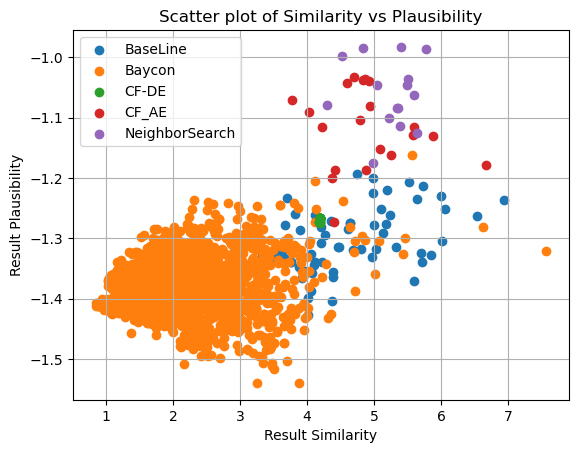

In [10]:
def plot(f1, f2, results_list, names):
    method_names = ["BaseLine", "Baycon", "CF-DE", "CF_AE", "NeighborSearch"]
    for idx, results in enumerate(results_list):
        result_x = [row[f1] for row in results]
        result_y = [row[f2] for row in results]

        plt.scatter(result_x, result_y, label=f"{method_names[idx]}")

    # Adding title and labels
    plt.title(f"Scatter plot of {names[f1]} vs {names[f2]}")
    plt.xlabel(f"Result {names[f1]}")
    plt.ylabel(f"Result {names[f2]}")
    plt.grid(True)

    # Show the legend to distinguish between different datasets
    plt.legend()
    plt.show()

plot(0,2, [results["Baseline"], results["Baycon"], results["CF-DE"], results["CF-AE"], results["NeighborSearch"]], names)

<Axes: >

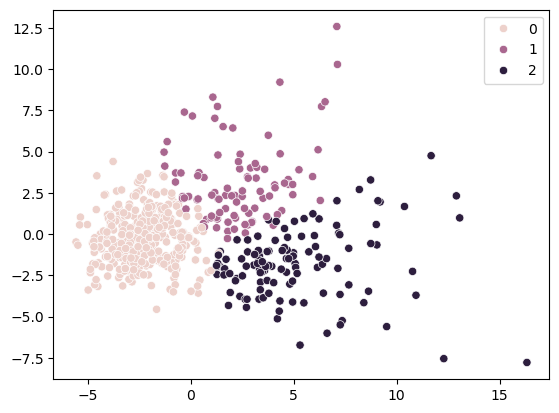

In [11]:
pca = PCA(n_components=2)
embed_X = pca.fit_transform(X)
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)

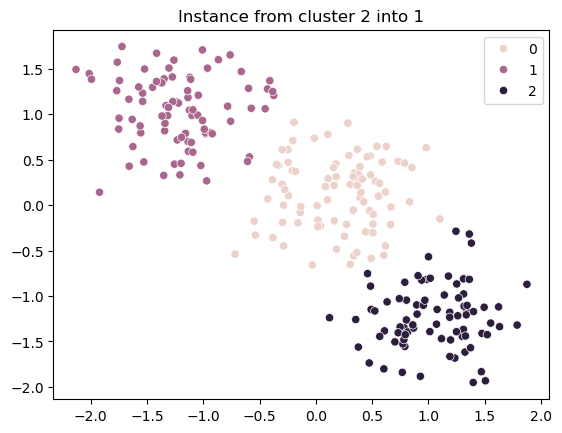

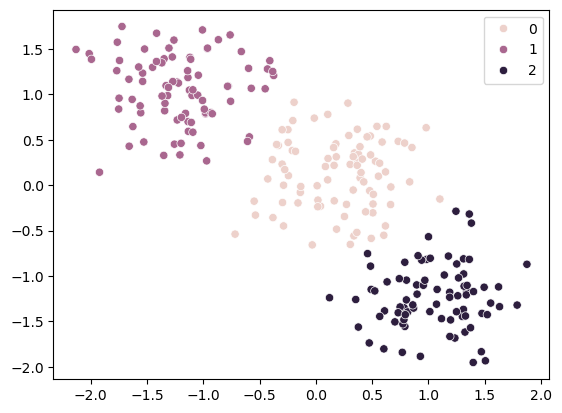

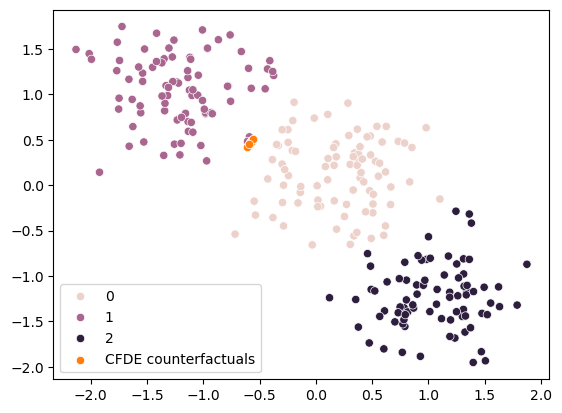

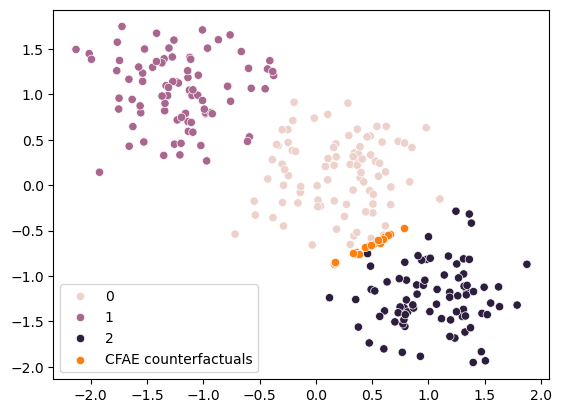

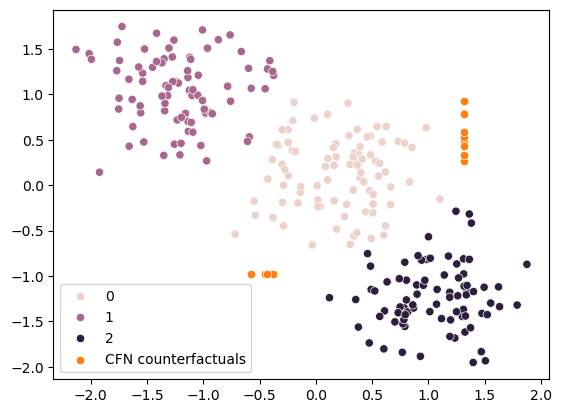

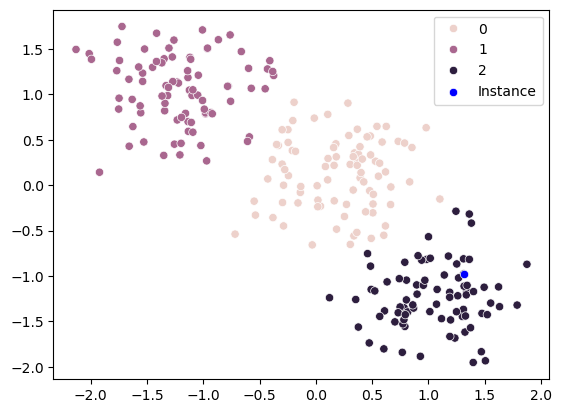

In [30]:
cf_n = 0
baseline_embed = baseline_cfs[cf_n].cf
baycon_embed = baycon_cfs[cf_n].cf
cfde_embed = np.array(cfde_cfs[cf_n].cf)
cfae_embed = np.array(cfae_cfs[cf_n].cf)
cfn_embed = np.array(ns_cfs[cf_n].cf)
instance_embedded = X[[baseline_cfs[cf_n].instance]]

ins_c = baseline_cfs[cf_n].instance_label
target_c = baseline_cfs[cf_n].target

plt.title(f"Instance from cluster {ins_c} into {int(target_c)}")
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
sns.scatterplot(x=baseline_embed[:, 0], y=baseline_embed[:, 1], label="Baseline counterfactuals")
plt.show()
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
sns.scatterplot(x=baycon_embed[:, 0], y=baycon_embed[:, 1], label="Baycon counterfactuals")
plt.show()
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
sns.scatterplot(x=cfde_embed[:, 0], y=cfde_embed[:, 1], label="CFDE counterfactuals")
plt.show()
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
sns.scatterplot(x=cfae_embed[:, 0], y=cfae_embed[:, 1], label="CFAE counterfactuals")
plt.show()
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
sns.scatterplot(x=cfn_embed[:, 0], y=cfn_embed[:, 1], label="CFN counterfactuals")
plt.show()
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
sns.scatterplot(x=instance_embedded[:, 0], y=instance_embedded[:, 1], label="Instance", color="blue")
plt.show()


## Running time

In [ ]:
import time
baseline_rt = 0.0
baycon_rt = 0.0
cfde_rt = 0.0
cfae_rt = 0.0
ns_rt = 0.0

it_rt = 5
for _ in range(it_rt):
    index = random.randint(0, len(X)-1)
    label = y[index]
    target = label
    while target == label:
        target = random.randint(0, nc-1)

    timestamp = time.time()
    classifier = RandomForestClassifier(n_estimators=100)
    baseline_cf = baseline_explainer(X, y, classifier, explainer, index, target_cluster=int(target))
    baseline_rt += time.time() - timestamp

    timestamp = time.time()
    t = Target(target_type="model_agnostic", target_feature="label", target_value=int(cf.target))
    baycon_cf, _predictions, _initial_instance, _initial_prediction = execute(df, model, t, index)
    baycon_rt += time.time() - timestamp

    timestamp = time.time()
    x1, cf1, h1 = CF_Descent(X=X,y=y,target=target,centers=centers,instance_index=index, stop_count=20)
    cfde_rt += time.time() - timestamp

    timestamp = time.time()
    x2, cf2, h2 = CF_Ascent(X=X,y=y,target=target,centers=centers,instance_index=index, stop_count=20, center_mode=False)
    cfae_rt += time.time() - timestamp

    timestamp = time.time()
    i_t, new_cfs_t = neighborSearch(X=X, y=y, target=target, kmeans=km, instance_index=index, n=10)
    ns_rt += time.time() - timestamp

baseline_rt /= it_rt
baycon_rt /= it_rt
cfde_rt /= it_rt
cfae_rt /= it_rt
ns_rt /= it_rt

print(f"Baseline: {baseline_rt}")
print(f"Baycon:   {baycon_rt}")
print(f"CFDE:     {cfde_rt}")
print(f"CFAE:     {cfae_rt}")
print(f"CFN:     {ns_rt}")


## RD-CFAE vs CFAE
*rd is random-direction

In [ ]:
n = 1
cfs_div = []
for i in range(n):
    index = random.randint(0, len(X)-1)
    label = y[index]
    target = label
    while target == label:
        target = random.randint(0, nc-1)
    
    cfs_div.append(CounterfactualData([], index, float(target), label))

amount = 70

cfae_cfs_div = []
for cf in cfs_div:
    temp_cfs = []
    for i in range(amount):
        x2, cf2, h2 = CF_Ascent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20)
        temp_cfs.append(cf2)
    cfae_cfs_div.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))

rd_cfae_cfs_div = []
for cf in cfs_div:
    temp_cfs = []
    for i in range(amount):
        x2, cf2, h2 = CF_Ascent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20, center_mode=False)
        temp_cfs.append(cf2)
    rd_cfae_cfs_div.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))

In [ ]:
cf_n = 0
cfae_embed = [pca.transform(v.cf) for v in cfae_cfs_div][cf_n]
rd_cfae_embed = [pca.transform(v.cf) for v in rd_cfae_cfs_div][cf_n]
instance_embedded = pca.transform(X[[cfae_cfs_div[cf_n].instance]])

ins_c = cfae_cfs_div[cf_n].instance_label
target_c = cfae_cfs_div[cf_n].target

plt.title(f"Instance from cluster {ins_c} into {int(target_c)}")
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)
sns.scatterplot(x=rd_cfae_embed[:,0], y=rd_cfae_embed[:,1], label="RD-CFAE counterfactuals")
sns.scatterplot(x=cfae_embed[:,0], y=cfae_embed[:,1], label="CFAE counterfactuals")
sns.scatterplot(x=instance_embedded[:,0], y=instance_embedded[:,1], label="Instance", color="blue")